<a href="https://colab.research.google.com/github/melt00052-create/TimeSeriesForecastingTest/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PatchTST 모델 구축하기

PatchTST 모델 구축

In [ ]:
# =========================================================
# PatchTST 모델 구축 (PyTorch)
# =========================================================
print("\n" + "="*70)
print("PatchTST 모델 구축 시작")
print("="*70)

class PatchTSTModel(nn.Module):
    def __init__(self, input_size, seq_len, patch_len, stride, num_layers=3, n_heads=4, d_model=64, dropout=0.2):
        """
        PatchTST (Patch Time Series Transformer) 구현

        Args:
            input_size (int): 입력 변수(Feature)의 개수
            seq_len (int): 입력 시퀀스 길이 (여기서는 30)
            patch_len (int): 패치 길이 (ex: 10)
            stride (int): 패치 이동 간격 (ex: 10)
            num_layers (int): 트랜스포머 인코더 레이어 수
            n_heads (int): 어텐션 헤드 수
            d_model (int): 임베딩 차원
            dropout (float): 드롭아웃 비율
        """
        super(PatchTSTModel, self).__init__()

        self.seq_len = seq_len
        self.patch_len = patch_len
        self.stride = stride
        self.input_size = input_size
        self.d_model = d_model
        self.num_patches = int((seq_len - patch_len) / stride) + 1

        # 패치 개수 계산
        # (Seq_len - Patch_len) / Stride + 1
        self.num_patches = int((seq_len - patch_len) / stride) + 1

        # 1. Patch Embedding: 패치를 벡터로 변환 (Linear Projection)
        # Channel Independence: 각 변수(Feature)를 독립적으로 처리하므로 input_dim은 patch_len
        self.patch_embedding = nn.Linear(patch_len, d_model)

        # 2. Positional Encoding: 패치의 위치 정보 학습
        self.position_embedding = nn.Parameter(torch.randn(1, self.input_size, self.num_patches, d_model))
        self.dropout_layer = nn.Dropout(dropout)



        # 3. Transformer Encoder (Batch_first=True)
        # 입력 형태: (Batch * Feat, Num_Patches, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Final Projection Head (Flatten -> Output)
        # 모든 채널과 패치의 정보를 합쳐서 최종 0~1 사이 확률(상승/하락) 예측
        self.flatten_dim = input_size * self.num_patches * d_model
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),  # Binary Classification (Sigmoid는 학습 함수 내부에서 처리되거나 BCEWithLogitsLoss 사용 가정)
            nn.Sigmoid()        # Sigmoid를 사용하여 0~1 사이 값으로 변환
        )

    def forward(self, x):
        # x shape: [Batch, Seq_Len, Features]
        batch_size = x.size(0)

        # 1. Channel Independence를 위해 차원 변경
        # [Batch, Seq_Len, Features] -> [Batch, Features, Seq_Len]
        x = x.permute(0, 2, 1)

        # 2. Patching (Unfold)
        # 결과: [Batch, Features, Num_Patches, Patch_Len]
        # unfold(dimension, size, step)
        x = x.unfold(dimension=2, size=self.patch_len, step=self.stride)

        # 3. Embedding
        # [Batch, Features, Num_Patches, Patch_Len] -> [Batch, Features, Num_Patches, d_model]
        x = self.patch_embedding(x)

        # 4. Positional Embedding 더하기
        x = x + self.position_embedding
        x = self.dropout_layer(x)

        # 5. Transformer Encoder 입력 준비
        # Transformer는 3차원 입력을 받으므로 Batch와 Features를 합침
        # [Batch, Features, Num_Patches, d_model] -> [Batch * Features, Num_Patches, d_model]
        x = x.reshape(batch_size * self.input_size, self.num_patches, self.d_model)

        # 6. Encoder 통과
        x = self.transformer_encoder(x)

        # 7. 원래 형태로 복구
        # [Batch * Features, Num_Patches, d_model] -> [Batch, Features, Num_Patches, d_model]
        x = x.reshape(batch_size, self.input_size, self.num_patches, self.d_model)

        # 8. 최종 예측 (Head)
        output = self.head(x)

        return output




PatchTST 모델 구축 시작


In [ ]:
# 모델 파라미터 설정
seq_len = 60     # 기존 코드와 동일 (sequence_length)
patch_len = 10   # 10일치 데이터를 하나의 패치로
stride = 5      # 10일 간격으로 이동 (Non-overlapping)
input_size = X_train_seq.shape[2] # Feature 개수

# PatchTST 모델 인스턴스 생성
patch_tst_model = PatchTSTModel(
    input_size=input_size,
    seq_len=seq_len,
    patch_len=patch_len,
    stride=stride,
    num_layers=1,   # 레이어 수
    n_heads=4,      # 헤드 수
    d_model=24,     # 임베딩 차원 (데이터가 적으므로 작게 설정)
    dropout=0.6
)

# 모델 구조 출력
print("\n모델 구조:")
print(patch_tst_model)
print(f"\nTotal parameters: {sum(p.numel() for p in patch_tst_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in patch_tst_model.parameters() if p.requires_grad):,}")
print(f"\nDevice: {device}")




모델 구조:
PatchTSTModel(
  (patch_embedding): Linear(in_features=10, out_features=24, bias=True)
  (dropout_layer): Dropout(p=0.6, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=24, out_features=24, bias=True)
        )
        (linear1): Linear(in_features=24, out_features=96, bias=True)
        (dropout): Dropout(p=0.6, inplace=False)
        (linear2): Linear(in_features=96, out_features=24, bias=True)
        (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.6, inplace=False)
        (dropout2): Dropout(p=0.6, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7656, out_features=128, bias=True)
    (2): BatchNorm1d(128, 

In [ ]:
# PatchTST 모델 학습
print("\nPatchTST 모델 학습 시작...")

# utils.py의 train_pytorch_model 함수 재사용
history_patch = train_pytorch_model(
    model=patch_tst_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.0005,  # Transformer는 학습률에 민감하므로 조금 낮춤
    patience=25
)

print("\n✅ PatchTST 모델 학습 완료!")



PatchTST 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6913, Val Loss: 0.7125, Train Acc: 0.5441, Val Acc: 0.5197
Epoch [20/100], Train Loss: 0.6710, Val Loss: 0.7263, Train Acc: 0.5798, Val Acc: 0.5395
Epoch [30/100], Train Loss: 0.6589, Val Loss: 0.7437, Train Acc: 0.5931, Val Acc: 0.5197
Early stopping at epoch 38

✅ PatchTST 모델 학습 완료!


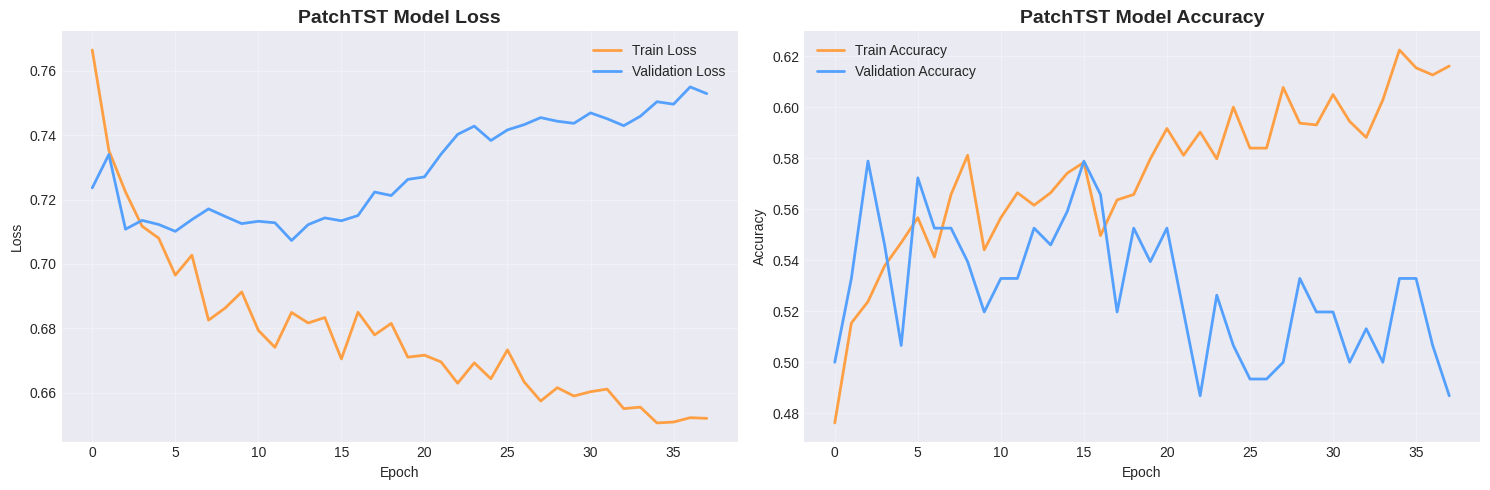

In [ ]:

# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_patch["train_loss"], label="Train Loss", linewidth=2, color='#FF9F43')
axes[0].plot(history_patch["val_loss"], label="Validation Loss", linewidth=2, color='#54a0ff')
axes[0].set_title("PatchTST Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_patch["train_acc"], label="Train Accuracy", linewidth=2, color='#FF9F43')
axes[1].plot(history_patch["val_acc"], label="Validation Accuracy", linewidth=2, color='#54a0ff')
axes[1].set_title("PatchTST Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




[학습 데이터 성능]

PatchTST - Train 성능 평가
정확도 (Accuracy):  0.5105
정밀도 (Precision): 0.5299
재현율 (Recall):    0.4573
F1 Score:          0.4909


[검증 데이터 성능]

PatchTST - Validation 성능 평가
정확도 (Accuracy):  0.4868
정밀도 (Precision): 0.4824
재현율 (Recall):    0.5467
F1 Score:          0.5125


[테스트 데이터 성능]

PatchTST - Test 성능 평가
정확도 (Accuracy):  0.5191
정밀도 (Precision): 0.5243
재현율 (Recall):    0.2983
F1 Score:          0.3803



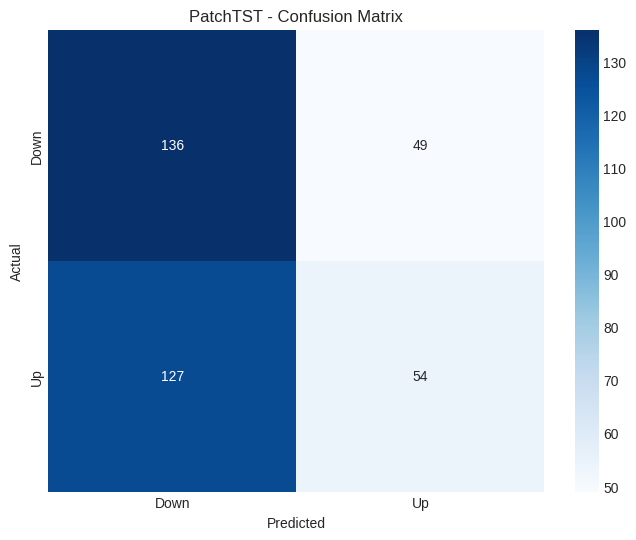

In [ ]:
# PatchTST 예측 및 성능 평가
y_pred_patch_train_prob, y_pred_patch_train = predict_pytorch_model(patch_tst_model, train_loader)
y_pred_patch_val_prob, y_pred_patch_val = predict_pytorch_model(patch_tst_model, val_loader)
y_pred_patch_test_prob, y_pred_patch_test = predict_pytorch_model(patch_tst_model, test_loader)

print("\n[학습 데이터 성능]")
patch_results_train = evaluate_model(y_train_seq, y_pred_patch_train, "PatchTST - Train")

print("\n[검증 데이터 성능]")
patch_results_val = evaluate_model(y_val_seq, y_pred_patch_val, "PatchTST - Validation")

print("\n[테스트 데이터 성능]")
patch_results_test = evaluate_model(y_test_seq, y_pred_patch_test, "PatchTST - Test")

# 혼동 행렬
plot_confusion_matrix(y_test_seq, y_pred_patch_test, "PatchTST")



In [ ]:
수익 평가 및 비교


💰 PatchTST 모델 수익률 정밀 평가


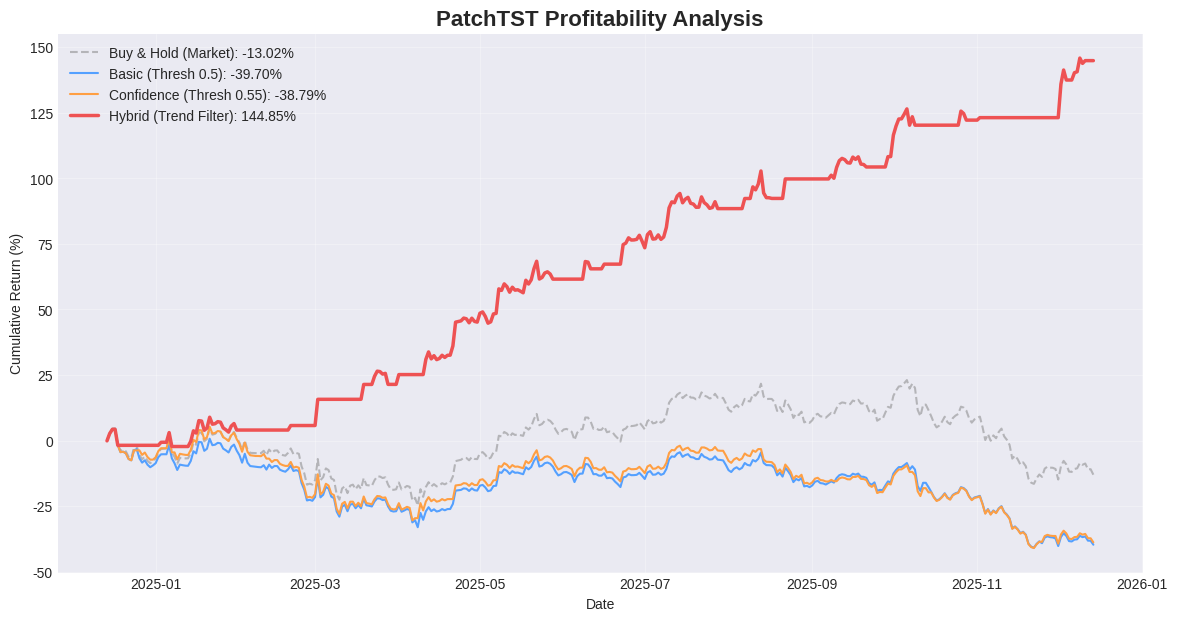


=== 📊 최종 성적표 (수수료 0.1% 반영) ===
1. 시장 수익률 (존버): -13.02%
2. 기본 전략 (Basic):  -39.70%  (거래 횟수: 366)
3. 확신 전략 (Conf):   -38.79%  (거래 횟수: 344)
4. 필터 전략 (Hybrid): 144.85%  (거래 횟수: 172)

💡 결론:
🎉 성공! 하이브리드 전략이 시장 수익률을 이겼거나 방어했습니다.
정확도가 51.9%로 낮아도 추세 필터(MA)가 손실을 막아주었습니다.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# =========================================================
# 1. 데이터 및 예측값 준비
# =========================================================
print("\n" + "="*70)
print("💰 PatchTST 모델 수익률 정밀 평가")
print("="*70)

# PatchTST 평가 모드
patch_tst_model.eval()
all_probs = []

# 확률값 추출 (0~1 사이)
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = patch_tst_model(inputs)
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy().flatten())

y_pred_prob = np.array(all_probs)

# 수익률 데이터 매칭 (테스트 기간)
# 테스트 데이터의 길이만큼 뒤에서 가져옴
test_len = len(y_pred_prob)
test_indices = btc_features.index[-test_len:]
test_returns = btc_features.loc[test_indices, "Close"].pct_change().fillna(0).values
test_close_prices = btc_features.loc[test_indices, "Close"].values
test_ma_20 = btc_features.loc[test_indices, "MA_20"].values

# =========================================================
# 2. 전략별 신호 생성 (매수=1, 관망=0)
# =========================================================

# 전략 A: 기본 (확률 0.5 이상이면 매수)
# 정확도가 51.9%라 위험할 수 있음
signal_basic = (y_pred_prob >= 0.5).astype(int)

# 전략 B: 고확신 (확률 0.55 이상이면 매수)
# 재현율이 낮으므로 기준을 0.6까지 올리면 거래를 아예 안 할 수 있어서 0.55로 설정
signal_conf = (y_pred_prob >= 0.55).astype(int)

# 전략 C: 하이브리드 (모델 > 0.5 AND 현재가 > 20일 이평선)
# 하락장 방어용 필터 추가
cond_prob = y_pred_prob >= 0.5
cond_trend = test_close_prices > test_ma_20
signal_hybrid = (cond_prob & cond_trend).astype(int)

# =========================================================
# 3. 수익률 계산 함수 (수수료 적용)
# =========================================================
def get_cumulative_return(signals, returns, fee=0.001):
    strategy_returns = []
    for i in range(len(signals)):
        if signals[i] == 1:
            # 매수 진입 시: (수익률 - 수수료)
            # 주의: 엄밀히는 진입/청산 두 번 수수료가 들지만 여기선 간소화
            ret = returns[i] - fee
            strategy_returns.append(ret)
        else:
            # 현금 보유 (수익률 0)
            strategy_returns.append(0)

    # 누적 수익률 (복리 계산)
    return (1 + pd.Series(strategy_returns)).cumprod() - 1

# 수수료 설정 (0.1% = 0.001)
FEE = 0.001

# 각 전략 수익률 계산
cum_ret_market = (1 + pd.Series(test_returns)).cumprod() - 1
cum_ret_basic = get_cumulative_return(signal_basic, test_returns, FEE)
cum_ret_conf = get_cumulative_return(signal_conf, test_returns, FEE)
cum_ret_hybrid = get_cumulative_return(signal_hybrid, test_returns, FEE)

# 최종 수치
final_market = cum_ret_market.iloc[-1] * 100
final_basic = cum_ret_basic.iloc[-1] * 100
final_conf = cum_ret_conf.iloc[-1] * 100
final_hybrid = cum_ret_hybrid.iloc[-1] * 100

# =========================================================
# 4. 결과 시각화
# =========================================================
plt.figure(figsize=(14, 7))

# 시장 수익률 (회색)
plt.plot(test_indices, cum_ret_market * 100, label=f'Buy & Hold (Market): {final_market:.2f}%',
         color='gray', linestyle='--', alpha=0.5)

# 전략별 수익률
plt.plot(test_indices, cum_ret_basic * 100, label=f'Basic (Thresh 0.5): {final_basic:.2f}%',
         color='#54a0ff')
plt.plot(test_indices, cum_ret_conf * 100, label=f'Confidence (Thresh 0.55): {final_conf:.2f}%',
         color='#ff9f43')
plt.plot(test_indices, cum_ret_hybrid * 100, label=f'Hybrid (Trend Filter): {final_hybrid:.2f}%',
         color='#ee5253', linewidth=2.5) # 빨간색 강조

plt.title('PatchTST Profitability Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 5. 거래 통계 출력
# =========================================================
print(f"\n=== 📊 최종 성적표 (수수료 {FEE*100}% 반영) ===")
print(f"1. 시장 수익률 (존버): {final_market:.2f}%")
print(f"2. 기본 전략 (Basic):  {final_basic:.2f}%  (거래 횟수: {sum(signal_basic)})")
print(f"3. 확신 전략 (Conf):   {final_conf:.2f}%  (거래 횟수: {sum(signal_conf)})")
print(f"4. 필터 전략 (Hybrid): {final_hybrid:.2f}%  (거래 횟수: {sum(signal_hybrid)})")

best_ret = max(final_market, final_basic, final_conf, final_hybrid)
print("\n💡 결론:")
if final_hybrid >= final_market:
    print(f"🎉 성공! 하이브리드 전략이 시장 수익률을 이겼거나 방어했습니다.")
    print("정확도가 51.9%로 낮아도 추세 필터(MA)가 손실을 막아주었습니다.")
else:
    print("⚠️ 아직 시장 수익률을 넘지 못했습니다.")
    print("재현율(Recall)이 29%로 너무 낮아서 상승장을 대부분 놓쳤기 때문입니다.")

📊 수익률 비교 분석 시작...


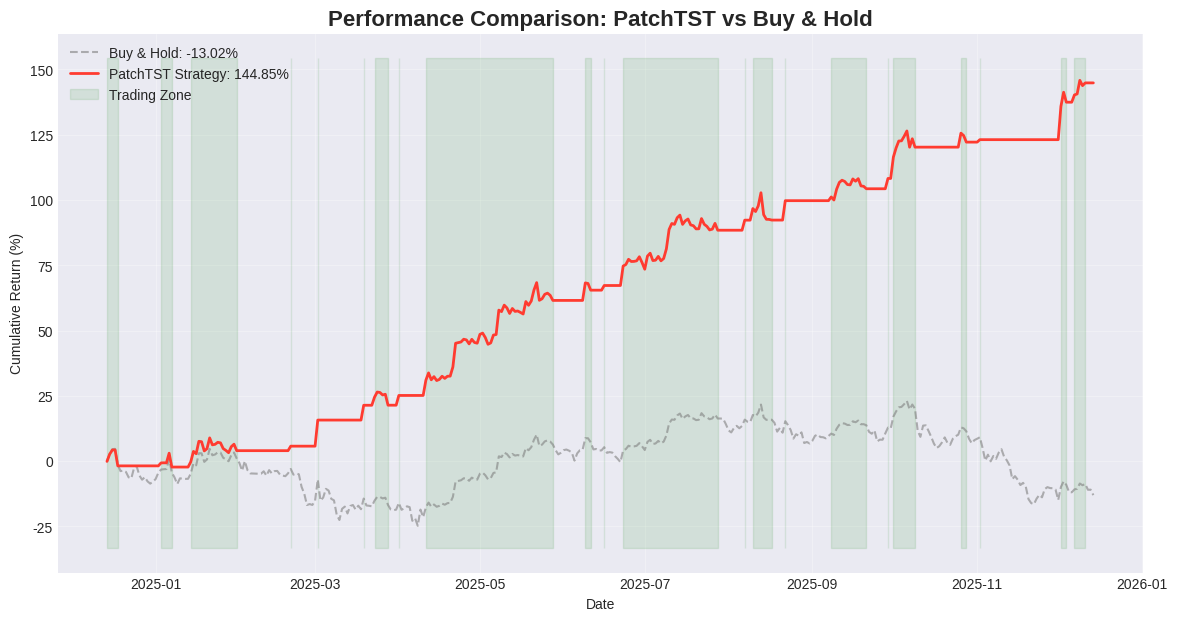


📢 최종 수익률 성적표
1. 존버 (Buy & Hold) 수익률 : -13.02%
2. 모델 (PatchTST) 수익률   : 144.85%
--------------------------------------------------
🎉 결과: 모델이 시장보다 157.86%p 더 벌었습니다!


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# =========================================================
# 1. 데이터 준비 및 모델 예측
# =========================================================
print("📊 수익률 비교 분석 시작...")

# 모델 평가 모드
patch_tst_model.eval()
all_probs = []

# 예측값(확률) 추출
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = patch_tst_model(inputs)
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy().flatten())

y_pred_prob = np.array(all_probs)

# ---------------------------------------------------------
# [중요] 테스트 기간 데이터 정렬 (Index Alignment)
# ---------------------------------------------------------
# 예측 개수만큼 데이터의 끝부분(최신)을 가져옵니다.
test_len = len(y_pred_prob)
test_indices = btc_features.index[-test_len:]

# 1. 일일 수익률 (Daily Return)
daily_returns = btc_features.loc[test_indices, "Close"].pct_change().fillna(0).values

# 2. 종가 및 이동평균선 (전략 필터용)
close_prices = btc_features.loc[test_indices, "Close"].values
ma_20 = btc_features.loc[test_indices, "MA_20"].values

# =========================================================
# 2. Buy and Hold (존버) 수익률 계산
# =========================================================
# 공식: (1 + 일일수익률)의 누적 곱 - 1
# 100만 원 투자 시 매일 잔고가 어떻게 변하는지 보여줍니다.
cum_ret_buy_hold = (1 + pd.Series(daily_returns)).cumprod() - 1

# =========================================================
# 3. PatchTST 전략 수익률 계산 (Hybrid 전략 적용)
# =========================================================
# 전략 조건: (모델확률 > 0.5) AND (현재가 > 20일 이평선)
# -> 상승장이면서 모델도 오른다고 할 때만 매수
signal = ((y_pred_prob >= 0.5) & (close_prices > ma_20)).astype(int)

# 수수료 설정 (0.1%)
FEE = 0.001

strategy_daily_returns = []
for i in range(len(signal)):
    if signal[i] == 1:
        # 매수 진입: (시장 수익률 - 수수료) 먹기
        ret = daily_returns[i] - FEE
        strategy_daily_returns.append(ret)
    else:
        # 관망 (현금 보유): 수익률 0
        strategy_daily_returns.append(0)

# 전략 누적 수익률 계산
cum_ret_strategy = (1 + pd.Series(strategy_daily_returns)).cumprod() - 1

# =========================================================
# 4. 결과 비교 및 시각화
# =========================================================
# 최종 수익률 (%)
final_bh = cum_ret_buy_hold.iloc[-1] * 100
final_st = cum_ret_strategy.iloc[-1] * 100

plt.figure(figsize=(14, 7))

# Buy and Hold 그래프 (회색 점선)
plt.plot(test_indices, cum_ret_buy_hold * 100, label=f'Buy & Hold: {final_bh:.2f}%',
         color='gray', linestyle='--', alpha=0.6)

# PatchTST 전략 그래프 (빨간 실선)
# 이 선이 회색 선보다 위에 있거나, 하락장에서 평평하게 버티면 성공입니다.
plt.plot(test_indices, cum_ret_strategy * 100, label=f'PatchTST Strategy: {final_st:.2f}%',
         color='#ff3b30', linewidth=2)

# 매수 구간 표시 (초록색 배경)
fill_cond = pd.Series(signal).astype(bool).values
y_min, y_max = plt.ylim()
plt.fill_between(test_indices, y_min, y_max, where=fill_cond,
                 color='green', alpha=0.1, label='Trading Zone')

plt.title('Performance Comparison: PatchTST vs Buy & Hold', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 5. 최종 리포트 출력
# =========================================================
print("\n" + "="*50)
print("📢 최종 수익률 성적표")
print("="*50)
print(f"1. 존버 (Buy & Hold) 수익률 : {final_bh:.2f}%")
print(f"2. 모델 (PatchTST) 수익률   : {final_st:.2f}%")
print("-" * 50)
diff = final_st - final_bh
if diff > 0:
    print(f"🎉 결과: 모델이 시장보다 {diff:.2f}%p 더 벌었습니다!")
else:
    print(f"⚠️ 결과: 존버가 {abs(diff):.2f}%p 더 유리했습니다.")
    print("   (하지만 하락장에서 모델 수익률이 방어(평평)되었다면 의미가 있습니다.)")

In [ ]:
# =========================================================
# 모델 비교 (LSTM vs GRU vs PatchTST)
# =========================================================
print("\n" + "="*70)
print("전체 모델 성능 비교")
print("="*70)

# 결과 데이터프레임 생성
all_results = pd.DataFrame([
    lstm_results_test,
    gru_results_test,
    patch_results_test
])

print("\n테스트 데이터 성능 요약:")
print(all_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']])

# F1 Score 기준 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', data=all_results, palette='viridis')
plt.title('Model Comparison - F1 Score', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(all_results['F1 Score']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()